# Mind Wandering
This notebook documents the mind wandering VR experiment in conjunction with biosignalsplux EEG and fNIRS sensor data.

## Experiment

The experiment induces and measures mind wandering by having the subject identify misspelled words in a long text. When a subject does not identify a misspelled word, we can say that they are not focused and consider them to be "mind-wandering" at that point in the experiment. The experiment controller uses eye tracking to watch the user's vision, so we can tracke exactly where they are in the text throughout the experiment. 

For the subject, the sequence of the experiment is as follows (the subject is wearing a VR headset with eye tracking enabled):

1. Read the tutorial. The tutorial explains the experiment and the controls.
2. Perform trial run. This is the same as the actual experiment, except it is much shorter and there are no misspelled words. It is just a sandbox for the subject to get used to the reading pace and the controls for marking words as misspelled.
3. Read full text. This is where the bulk of the experiment happens. It takes roughly 20 minutes to get through the full text.
4. Answer questions. There are a couple multiple choice questions at the end of the experiment for the subject to answer. The responses are recorded in a json file.

## Type I and II Errors
$$H_0 \equiv \text{Word is not misspelled}$$
$$H_a \equiv \text{Word is misspelled}$$
The user can make two errors:
- Type I: Marking a correctly spelled word
- Type II: Skipping an incorrectly spelled word

We expect type II errors to signifify mind-wandering, however type I errors are also discussed.

## Images

Below are two images from the subject's perspective in VR. Note that since the subject is in VR these look slightly warped.

![Reading](assets/reading.jpg "Regular Reading")

*Figure 1: An example of what the user might see during the experiment*

![Misspelled](assets/misspelled.jpg "Misspelled Word")

*Figure 2: The user marked the word "potter" as misspelled*

## Example Data and Processing

This notebook contains data from an example run of the experiment. Reza did this with the plux EEG and fNIRS sensors on him. The EEG was set with the active electrode at F7 and the reference at Fp1. The fNIRS was set at the middle of the browline on Fpz.

In [1]:
import pandas as pd
import numpy as np
import json
import datetime as dt
import biosignalsnotebooks as bsnb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, Markdown
from dateutil import parser

from utils.multitaper_spectogram_python import multitaper_spectrogram

In [2]:
vr_filepath = "mind-wandering-152412.csv"
questions_filepath = "mind-wandering-152412-questions.json"
plux_filepath = "reza_mind_wandering.txt"

In [3]:
# LOAD PLUX DATA

with open(plux_filepath) as plux:
    header = json.loads(plux.readlines()[1][1:])
    
    key = list(header.keys())[0]
    #plux_start = header.get
    #print(json.dumps(header[key], indent=4))
    plux_date = header[key]["date"]
    plux_time = header[key]["time"]

    plux_start = dt.datetime.strptime(plux_date + " " + plux_time, "%Y-%m-%d %H:%M:%S.%f")
   

    plux_sampling_rate = header[key]["sampling rate"]
    plux_resolution = header[key]["resolution"][0]

    plux_columns = header[key]["column"]
    #print(plux_columns)

    #print(plux_sampling_rate, plux_start)

plux_raw = np.loadtxt(plux_filepath, skiprows=3)
plux_data = pd.DataFrame(plux_raw, columns=plux_columns)
plux_data["time"] = plux_data["nSeq"].apply(lambda t: plux_start + dt.timedelta(seconds=t/plux_sampling_rate))

display(plux_data)


,nSeq,DI,CH1,CH9A,CH9B,time
0,0.0,0.0,30760.0,0.0,0.0,2021-12-15 15:00:34.949
1,1.0,0.0,29304.0,0.0,0.0,2021-12-15 15:00:34.950
2,2.0,0.0,28484.0,4527.0,134380.0,2021-12-15 15:00:34.951
3,3.0,0.0,28800.0,4527.0,134380.0,2021-12-15 15:00:34.952
4,4.0,0.0,28840.0,105060.0,174547.0,2021-12-15 15:00:34.953
...,...,...,...,...,...,...
1445845,1445845.0,0.0,34930.0,97021.0,107321.0,2021-12-15 15:24:40.794
1445846,1445846.0,0.0,27624.0,96891.0,107291.0,2021-12-15 15:24:40.795
1445847,1445847.0,0.0,16112.0,96891.0,107291.0,2021-12-15 15:24:40.796
1445848,1445848.0,0.0,7238.0,97911.0,107267.0,2021-12-15 15:24:40.797


In [4]:
# LOAD VR DATA

vr_data = pd.read_csv(vr_filepath)

vr_data["time"] = vr_data["Time"].apply(lambda t: parser.parse(t[:-6]))
vr_data["time"] = pd.to_datetime(vr_data["time"])

display(Markdown("## All VR Data"))
display(vr_data)

type_i = vr_data[~vr_data["Misspelled"] & vr_data["Triggered"]]
type_ii = vr_data[vr_data["Misspelled"] & ~vr_data["Triggered"]]

display(Markdown("## Type I Errors"))
display(type_i)

display(Markdown("## Type II Errors"))
display(type_ii)

## All VR Data

,Time,Section,Index,Line,Word,Misspelled,Triggered,time
0,2021-12-15T15:02:17.7571456-05:00,0,5,0,lived,False,False,2021-12-15 15:02:17.757145
1,2021-12-15T15:02:17.8821479-05:00,0,4,0,there,False,False,2021-12-15 15:02:17.882147
2,2021-12-15T15:02:18.0721473-05:00,0,3,0,village,False,False,2021-12-15 15:02:18.072147
3,2021-12-15T15:02:18.3771458-05:00,0,2,0,small,False,False,2021-12-15 15:02:18.377145
4,2021-12-15T15:02:18.5441493-05:00,0,2,0,small,False,False,2021-12-15 15:02:18.544149
...,...,...,...,...,...,...,...,...
3875,2021-12-15T15:22:57.3686071-05:00,1,2160,272,+,False,False,2021-12-15 15:22:57.368607
3876,2021-12-15T15:22:57.5806064-05:00,1,2159,272,+,False,False,2021-12-15 15:22:57.580606
3877,2021-12-15T15:22:57.5916062-05:00,1,2160,272,+,False,False,2021-12-15 15:22:57.591606
3878,2021-12-15T15:22:57.9607454-05:00,1,2159,272,+,False,False,2021-12-15 15:22:57.960745


## Type I Errors

,Time,Section,Index,Line,Word,Misspelled,Triggered,time
46,2021-12-15T15:02:35.0871861-05:00,0,40,4,his,False,True,2021-12-15 15:02:35.087186
94,2021-12-15T15:02:48.9491568-05:00,0,71,8,donkey,False,True,2021-12-15 15:02:48.949156
139,2021-12-15T15:03:03.7494055-05:00,0,103,12,donkey,False,True,2021-12-15 15:03:03.749405
364,2021-12-15T15:04:15.8848730-05:00,0,266,32,behavior.,False,True,2021-12-15 15:04:15.884873
428,2021-12-15T15:04:37.7318720-05:00,0,316,38,bonded,False,True,2021-12-15 15:04:37.731872
451,2021-12-15T15:04:45.5508744-05:00,0,331,40,+,False,True,2021-12-15 15:04:45.550874
507,2021-12-15T15:05:53.6755005-05:00,1,31,3,lever,False,True,2021-12-15 15:05:53.675500
577,2021-12-15T15:06:13.2900069-05:00,1,79,9,recuperation.,False,True,2021-12-15 15:06:13.290006
676,2021-12-15T15:06:39.8630164-05:00,1,144,16,sensation,False,True,2021-12-15 15:06:39.863016
897,2021-12-15T15:07:49.6408598-05:00,1,291,35,uncrated,False,True,2021-12-15 15:07:49.640859


## Type II Errors

,Time,Section,Index,Line,Word,Misspelled,Triggered,time
679,2021-12-15T15:06:42.2760173-05:00,1,147,17,doshmanxy,True,False,2021-12-15 15:06:42.276017
1420,2021-12-15T15:10:34.5075362-05:00,1,643,81,pretconfexz,True,False,2021-12-15 15:10:34.507536
1630,2021-12-15T15:11:36.0315262-05:00,1,773,98,emonfulxx,True,False,2021-12-15 15:11:36.031526
1635,2021-12-15T15:11:37.3715263-05:00,1,773,98,emonfulxx,True,False,2021-12-15 15:11:37.371526
1637,2021-12-15T15:11:38.2205241-05:00,1,773,98,emonfulxx,True,False,2021-12-15 15:11:38.220524
1639,2021-12-15T15:11:39.3155271-05:00,1,773,98,emonfulxx,True,False,2021-12-15 15:11:39.315527
1984,2021-12-15T15:13:24.3008943-05:00,1,1001,127,zxembling,True,False,2021-12-15 15:13:24.300894
2045,2021-12-15T15:13:42.8648942-05:00,1,1051,133,cabuggyxy,True,False,2021-12-15 15:13:42.864894
2054,2021-12-15T15:13:45.2888943-05:00,1,1051,133,cabuggyxy,True,False,2021-12-15 15:13:45.288894
3233,2021-12-15T15:20:00.2037441-05:00,1,1762,224,grashxyzli.,True,False,2021-12-15 15:20:00.203744


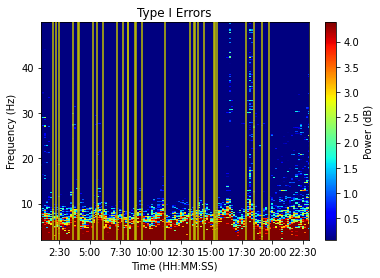

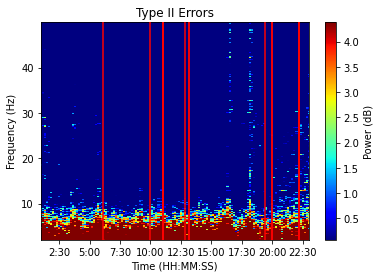

In [5]:
eeg_data = plux_data["CH1"]

eeg_uv = bsnb.raw_to_phy("EEG", "biosignalsplux", eeg_data, plux_resolution, "uV")
time_uv = bsnb.generate_time(eeg_uv, plux_sampling_rate)

type_i_times = []
for idx, i in type_i.iterrows():
    t = (i["time"] - plux_start).total_seconds()
    type_i_times.append(t)

type_ii_times = []
for idx, ii in type_ii.iterrows():
    t = (ii["time"] - plux_start).total_seconds()
    type_ii_times.append(t)

##print(type_i_times)
#print(type_ii_times)
    #print(i["time"] - plux_start)

#plt.title("Spectogram")

plt.title("Type I Errors")
spect, stimes, sfreqs = multitaper_spectrogram(eeg_uv, plux_sampling_rate, frequency_range=[2, 50], window_params=[120, 10], type_i_times=type_i_times, verbose=False)

plt.title("Type II Errors")
spect, stimes, sfreqs = multitaper_spectrogram(eeg_uv, plux_sampling_rate, frequency_range=[2, 50], window_params=[120, 10], type_ii_times=type_ii_times, verbose=False)

In [6]:
with open(questions_filepath) as f:
    questions = json.load(f)

display(Markdown("## End of Experiment Survey Questions"))

for q in questions["questions"]:
    display(Markdown(f"**{q['question']}**"))
    display(Markdown(f"*{q['choice']}*"))

## End of Experiment Survey Questions

**Are you ready to begin?**

*Yes*

**After how many hours the pill lost its effect?**

*2 hours*

**Did you mind wander reading the essay?**

*Yes*

**Approximately, how many times did you mind wander?**

*More than 5 times*

**Was the essay too hard to understand?**

*Yes*

**Did you skip some parts of the text?**

*Yes*